# Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', None)

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# Looking at the Data

In [2]:
data = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', sep='\t')
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Feature Engineering

We will generate some new features which may help in better customer segmentation. 
Following are the new features generated along with their transformations.

In [4]:
data = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', sep='\t')
'''1. Sum total of all the expenses in all the categories since last 2 years'''
data['TotalSpend'] = (data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] +
                      data['MntGoldProds'] + data['MntFishProducts'] + data['MntSweetProducts'])

'''2. Sum total of all the purchase counts across channels. Dropping where total purchase count is zero, as it cant be if total spend is a
non-zero column'''
data['TotalPurchaseCount'] = (data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'])
data = data.loc[data['TotalPurchaseCount']!=0]

'''3. Percentage of purchase through each of the 3 channels - In-store, catalogue, online'''
data['inStorePercent'] = (data['NumStorePurchases']/data['TotalPurchaseCount'])
data['cataloguePercent'] = (data['NumCatalogPurchases']/data['TotalPurchaseCount'])
data['onlinePercent'] = (data['NumWebPurchases']/data['TotalPurchaseCount'])

'''4. Ratio of in-store to out-of-store purchases'''
data.loc[((data['NumWebPurchases']==0) & (data['NumCatalogPurchases']==0)),'inStoreToRemoteRatio'] = 0
data.loc[data[['NumWebPurchases', 'NumCatalogPurchases']].sum(axis=1) != 0, 'inStoreToRemoteRatio'] = data['NumStorePurchases']/(data['NumWebPurchases'] + data['NumCatalogPurchases'])

'''5. Categorize customers basis number of discount puchases - zero, low, medium, high'''
data.loc[data['NumDealsPurchases'] == 0, 'CatDealsPurchases'] = 'zero'
data.loc[(data['NumDealsPurchases'] > 0) & (data['NumDealsPurchases'] <= 3), 'CatDealsPurchases'] = 'low'
data.loc[(data['NumDealsPurchases'] > 3) & (data['NumDealsPurchases'] <= 8), 'CatDealsPurchases'] = 'medium'
data.loc[(data['NumDealsPurchases'] > 8), 'CatDealsPurchases'] = 'high'

'''6. Calculate the ratio of Discounted purchases to total purchases made'''
data['discountedPurchasePercent'] = (data['NumDealsPurchases']/data['TotalPurchaseCount'])

'''7. Campaigning Bool - Any ad campaign successful on the customer?'''
data['campaignSuccessBool'] = 0
data.loc[(data['AcceptedCmp1'] == 1) | (data['AcceptedCmp2'] == 1) | (data['AcceptedCmp3'] == 1) |
          (data['AcceptedCmp4'] == 1) | (data['AcceptedCmp5'] == 1) | (data['Response'] == 1), 'campaignSuccessBool'] = 1

'''8. Ratio of web visits to web purchases - Number of visits it took for a unit purchase made'''
data.loc[(data['NumWebVisitsMonth']==0)|(data['NumWebPurchases']==0),'convertedWebVisits'] = 0
data.loc[(data['convertedWebVisits']!=0),'convertedWebVisits'] = (data['NumWebVisitsMonth']/data['NumWebPurchases'])

'''9. Catalogue-based purchases in 2020s are unique. They should be tracked separately too'''
data['catalogueCustomerBool'] = 0
data.loc[(data['NumCatalogPurchases'] > 0), 'catalogueCustomerBool'] = 1

'''10. Customer Age at 2015 (Last customer registration was in late 2014 as per the dataset)'''
data['Age'] = 2015 - data["Year_Birth"]

'''11. Customer active age'''
data['customerActiveAge'] = ((pd.to_datetime('01-01-2015') - pd.to_datetime(data['Dt_Customer'], format = '%d-%m-%Y')).dt.days)/365
data['customerActiveAge'] = data['customerActiveAge'].round(2)

'''12. Kid at home, Teen at home bools'''
data["kidAtHomeBool"] = np.where(data.Kidhome > 0, 1, 0)
data["teenAtHomeBool"] = np.where(data.Teenhome > 0, 1, 0)

'''13. IsParent Boolean'''
data['isParentBool'] = np.where((data.kidAtHomeBool ==1) | (data.teenAtHomeBool ==1), 1,0)

'''14. Simplify Marital Status by adding an IsMarried Bool and collapsing the categories to just Partner, Single'''
data['isMarriedBool'] = np.where(data.Marital_Status == 'Married',1,0)
replace_dict = {'Married': 'Partner', 'Together': 'Partner', 'Absurd': 'Single',
                'Alone' : 'Single', 'Divorced' : 'Single', 'Widow' : 'Single', 'YOLO' : 'Single'}
data['Marital_Status'] = data['Marital_Status'].replace(to_replace=replace_dict)

'''15. Number of people in the household'''
data['householdSize'] = (1 + data['Teenhome'] + data['Kidhome'])
data.loc[data['Marital_Status'] == 'Partner', 'householdSize'] += 1


'''16. Convert Recency to number of weeks from days'''
data['Recency'] /= 7

'''17. Average Purchase Value'''
data['avgPurchaseValue'] = data['TotalSpend']/data['TotalPurchaseCount']

'''18. Drop unnecessary columns'''
drop_columns = ['ID','Year_Birth','Dt_Customer','Z_CostContact', 'Z_Revenue']
data = data.drop(columns = drop_columns)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2234 entries, 0 to 2239
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  2234 non-null   object 
 1   Marital_Status             2234 non-null   object 
 2   Income                     2210 non-null   float64
 3   Kidhome                    2234 non-null   int64  
 4   Teenhome                   2234 non-null   int64  
 5   Recency                    2234 non-null   float64
 6   MntWines                   2234 non-null   int64  
 7   MntFruits                  2234 non-null   int64  
 8   MntMeatProducts            2234 non-null   int64  
 9   MntFishProducts            2234 non-null   int64  
 10  MntSweetProducts           2234 non-null   int64  
 11  MntGoldProds               2234 non-null   int64  
 12  NumDealsPurchases          2234 non-null   int64  
 13  NumWebPurchases            2234 non-null   int64  
 1

There are 24 null values for income. Instead of dropping them let's try to impute them using simple regression.
TotalSpend and Income share a nice, clean linear model

# Filling Null values : Linear Model

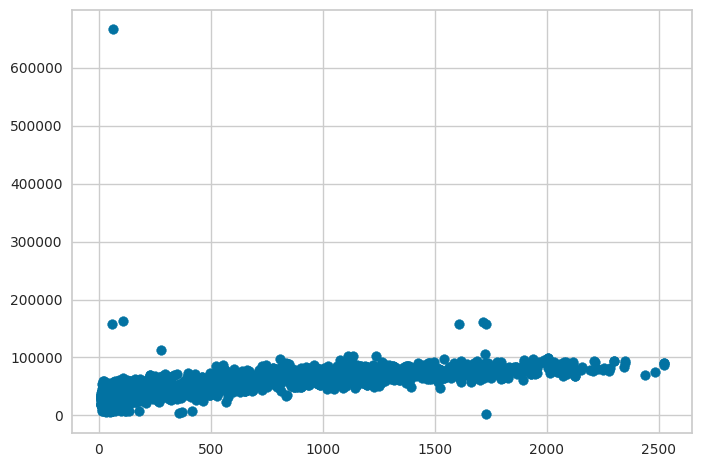

In [6]:
plt.scatter(x= data['TotalSpend'], y = data['Income'])

We'll drop rows where income > 180,000, and then fit a linear model. This will remove outliers and not affect the slope

## Fit a linear model

In [7]:
data = data.loc[(data['Income']<200000) | (data['Income'].isna())]
data = data[(data["Age"]<90)]

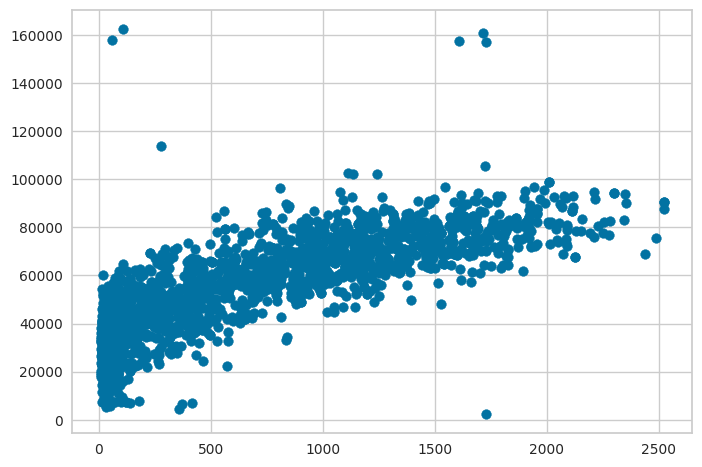

In [8]:
plt.scatter(x= data['TotalSpend'], y = data['Income'])

In [9]:
X = data.loc[data['Income']<120000, 'TotalSpend'].values.reshape(-1, 1)
y = data.loc[data['Income']<120000, 'Income'].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

## Visualize the linear model

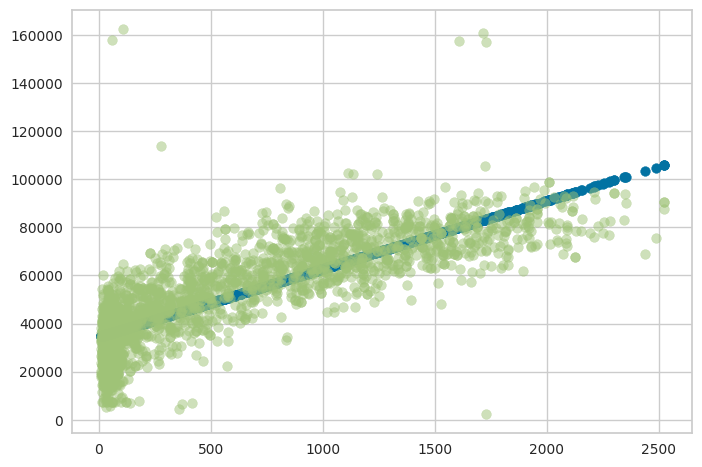

In [10]:
plt.scatter(X, lin_reg.predict(X))
plt.scatter(x= data['TotalSpend'], y = data['Income'], alpha = 0.5)

In [11]:
data.loc[data['Income'].isna(),'Income'] = lin_reg.predict(data.loc[data['Income'].isna(),'TotalSpend'].values.reshape(-1, 1))

In [12]:
'''Income, TotalExpenditure per people in the household'''
data['incomePerPerson'] = (data['Income']/data['householdSize'])
data['expensePerPerson'] = (data['TotalSpend']/data['householdSize'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2230 entries, 0 to 2239
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  2230 non-null   object 
 1   Marital_Status             2230 non-null   object 
 2   Income                     2230 non-null   float64
 3   Kidhome                    2230 non-null   int64  
 4   Teenhome                   2230 non-null   int64  
 5   Recency                    2230 non-null   float64
 6   MntWines                   2230 non-null   int64  
 7   MntFruits                  2230 non-null   int64  
 8   MntMeatProducts            2230 non-null   int64  
 9   MntFishProducts            2230 non-null   int64  
 10  MntSweetProducts           2230 non-null   int64  
 11  MntGoldProds               2230 non-null   int64  
 12  NumDealsPurchases          2230 non-null   int64  
 13  NumWebPurchases            2230 non-null   int64  
 1

In [14]:
def category_plot(df, target, cat_cols):
    
    df = df[cat_cols].astype('category')
    nrows = len(cat_cols)
    ncols = 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(12,nrows*5))
    for i, col in enumerate(cat_cols):
        sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index, ax=axs[i,0])
        sns.boxplot(x=col, y=target, data=df, ax=axs[i,1])
        axs[i,0].set_title(f"Distribution of {col}. Null:{round(100*(df[col].isnull().sum()/len(df)),2)}%")
        axs[i,1].set_title(f"Boxplot of {col}.")
        
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [15]:
cat_columns = ['Education', 'Marital_Status','CatDealsPurchases','Teenhome','Kidhome','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases',
                      'NumStorePurchases','NumWebVisitsMonth','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
                      'AcceptedCmp1','AcceptedCmp2','Complain','Response', 'campaignSuccessBool',
           'catalogueCustomerBool','kidAtHomeBool','teenAtHomeBool','isParentBool','isMarriedBool']
#category_plot(data, data['TotalSpend'], cat_cols = cat_columns)

In [16]:
def numerical_plot(dataset, columns, target='TotalSpend'):
    nrows = len(columns)
    ncols = 3
    figure, axs = plt.subplots(nrows, ncols, figsize = (20,nrows*7))
    
    for i, column in enumerate(columns):
        sns.histplot(dataset[column], fill = True, kde= True, ax=axs[i,0])
        sns.boxplot(dataset[column], ax=axs[i,1])
        sns.scatterplot(x=dataset[column], y=dataset[target], ax=axs[i,2])
        axs[i,0].set_title(f"Dist. of {column}; Skew:{round(dataset[column].skew(),2)}; Null:{round(100*(dataset[column].isnull().sum()/len(dataset)),2)}%")
        axs[i,1].set_title(f"Boxplot of {column}")
        axs[i,2].set_title(f"Scatterplot of {target} v. {column}")
    plt.tight_layout()
    plt.show()       

In [17]:
num_columns = data.select_dtypes(include='number').columns
rem_num_columns = set(num_columns) - set(cat_columns)
rem_num_columns = list(rem_num_columns)
#numerical_plot(data, rem_num_columns, target='TotalSpend')

# Data Pre-processing for cluster analysis

In [18]:
# Label encoding for categorical columns
customer = data.copy()

object_cols = customer.select_dtypes(include='object').columns
#customer = pd.get_dummies(customer, columns=object_cols, drop_first=True, dtype=int)

LE=LabelEncoder()
for i in object_cols:
    customer[i]=customer[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

#Scaling
scaler = StandardScaler()
scaler.fit(customer)
customer = pd.DataFrame(scaler.transform(customer),columns= customer.columns )
print("All features are now scaled")
print(f"Shape of the final pre-processed dataset is : {customer.shape}")

All features are now numerical
All features are now scaled
Shape of the final pre-processed dataset is : (2230, 45)


# Correlation Analysis

In [19]:
matrix = customer.corr()

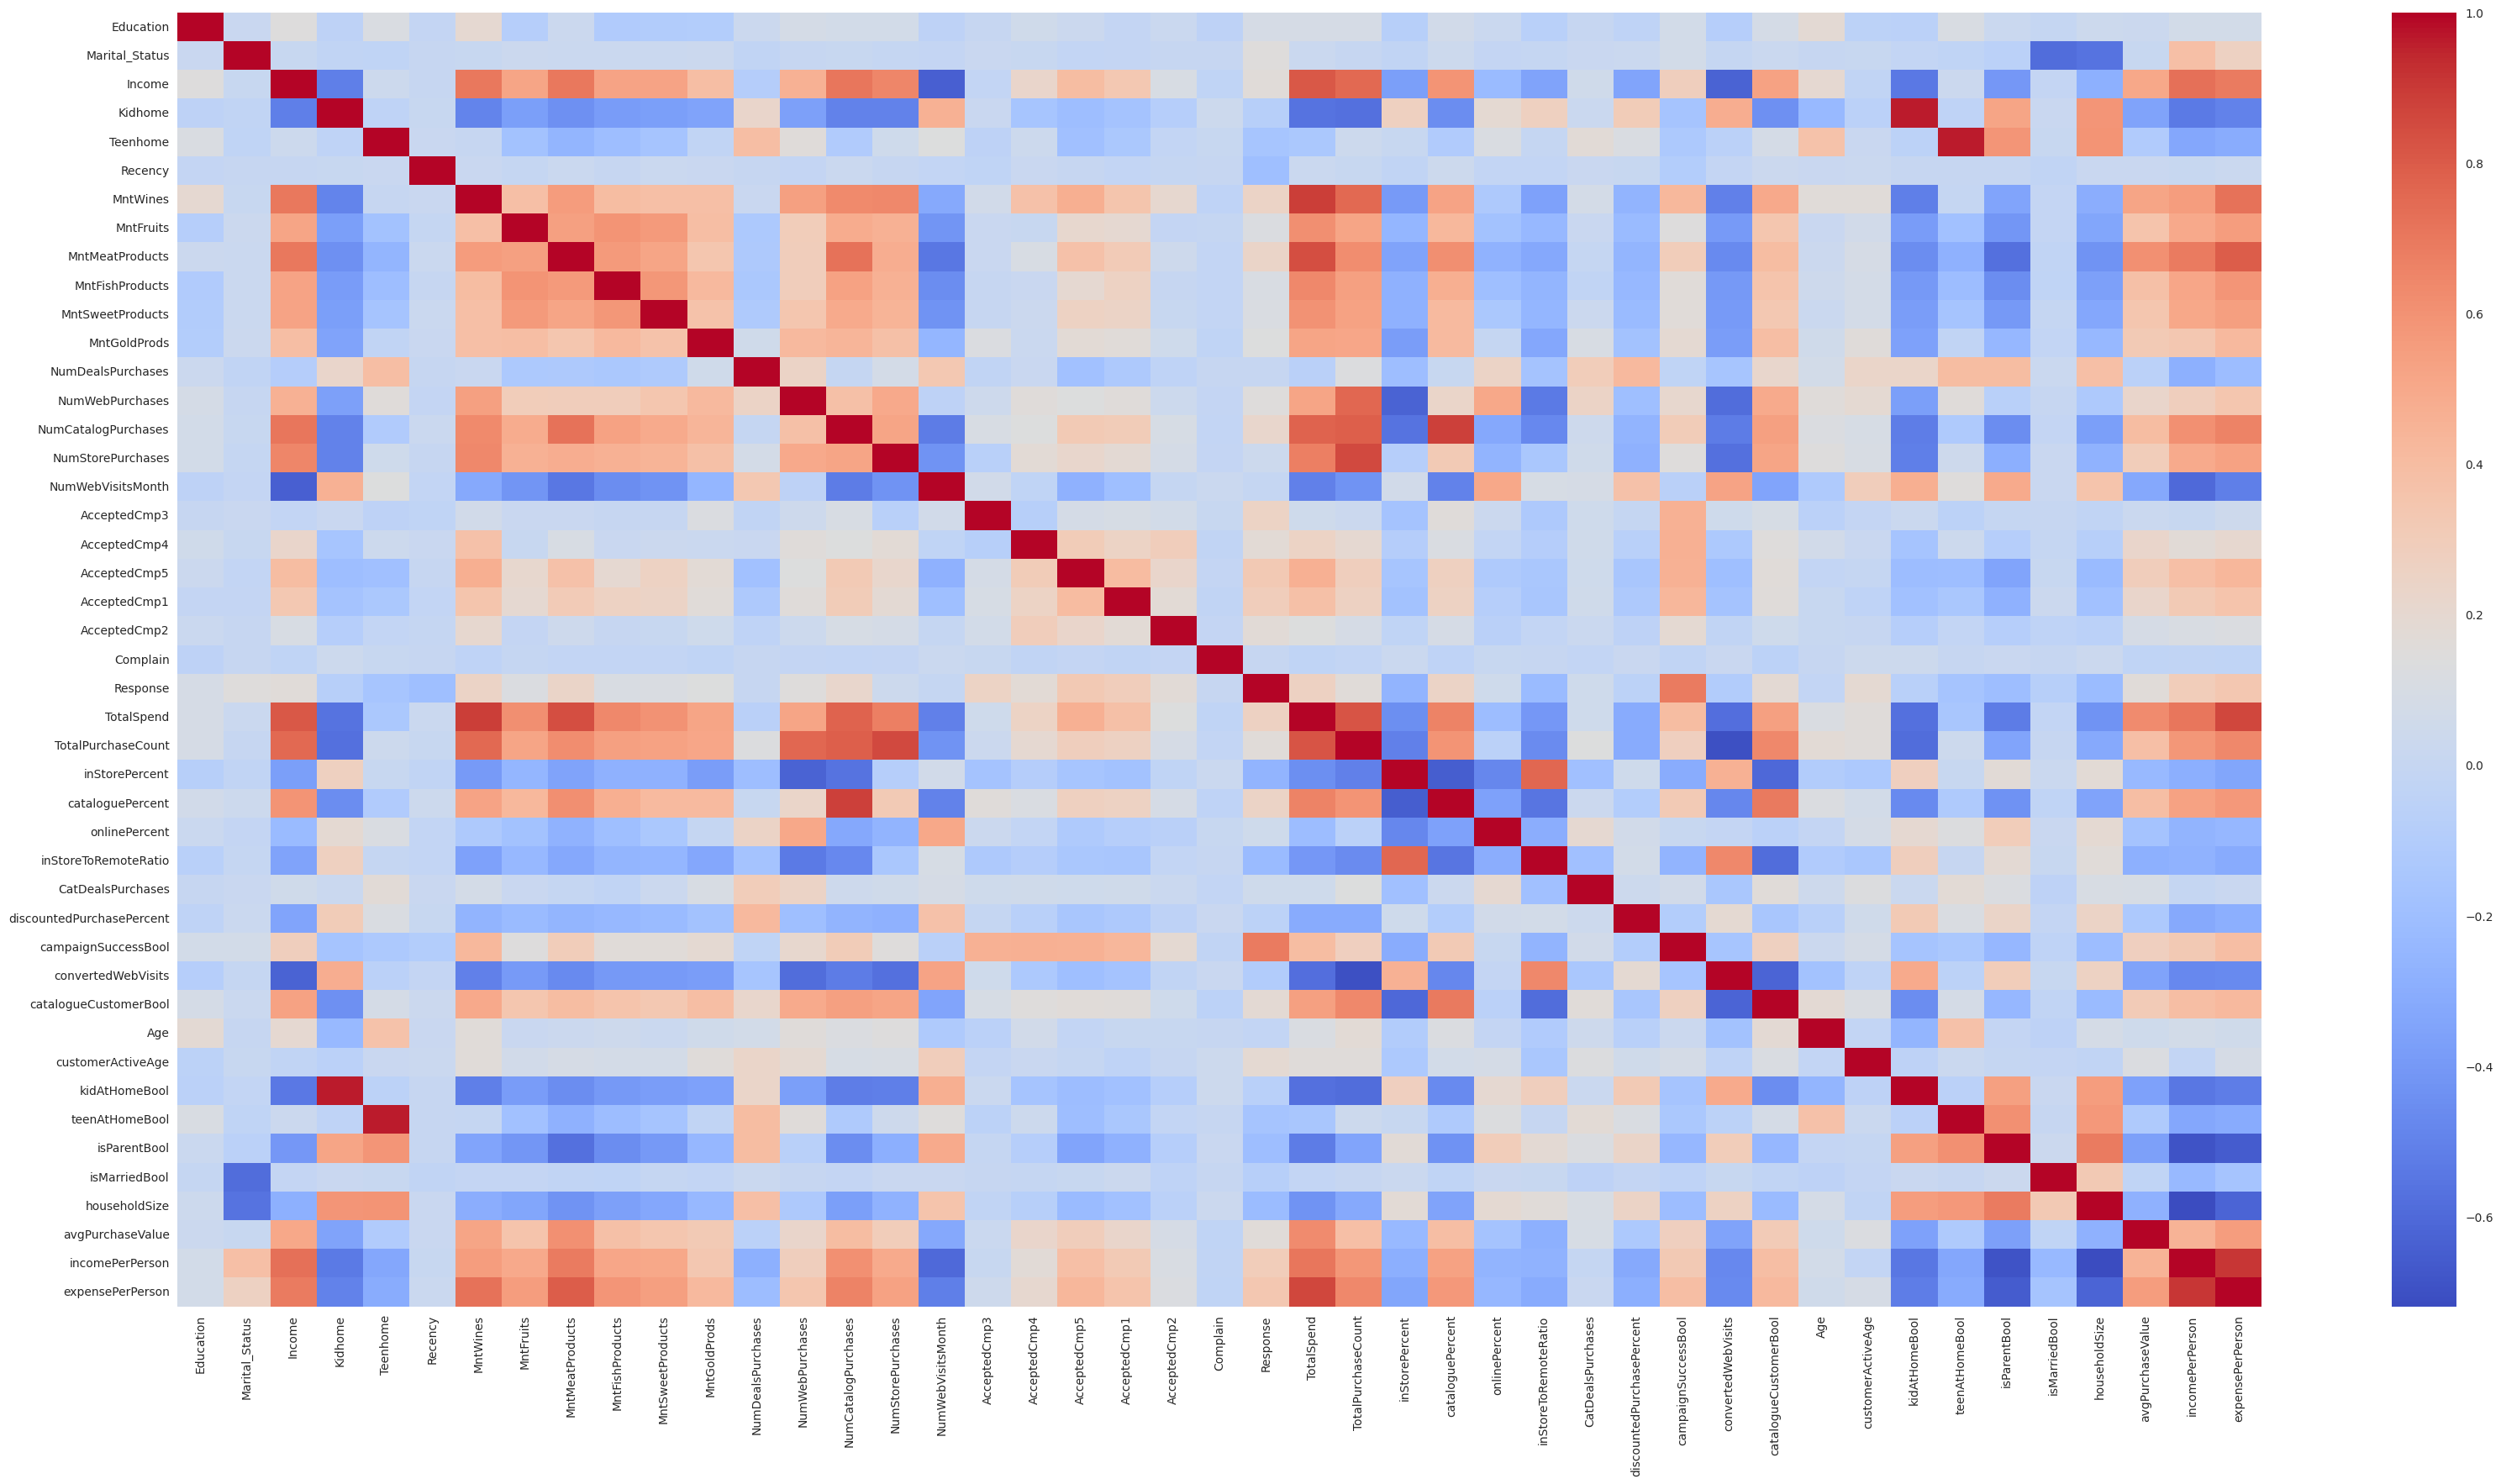

In [20]:
fig, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(matrix, annot=False, cmap='coolwarm')
plt.show()

# Dimensionality Reduction using PCA

For better interpretability, we will reduce the number of dimensions to 3 using PCA.     
This will definitly lead to information loss but will save us from the curse of dimensionality when we apply clustering algorithms

In [21]:
customer_filter = customer.copy()
pca = PCA(n_components=3)  # Choose 3 principal components
pca.fit(customer_filter)

#  Transform the scaled features to the new PCA space
customer_pca = pca.transform(customer_filter)

'''# Scaling the features again post PCA
scaler = StandardScaler()
scaler.fit(customer_pca)'''

# Fetching a pandas DataFrame for the standard scaled PCA matrix
# customer_pca = pd.DataFrame(scaler.transform(customer_pca),columns=['PC1', 'PC2', 'PC3'] )
customer_pca = pd.DataFrame(customer_pca,columns=['PC1', 'PC2', 'PC3'] )

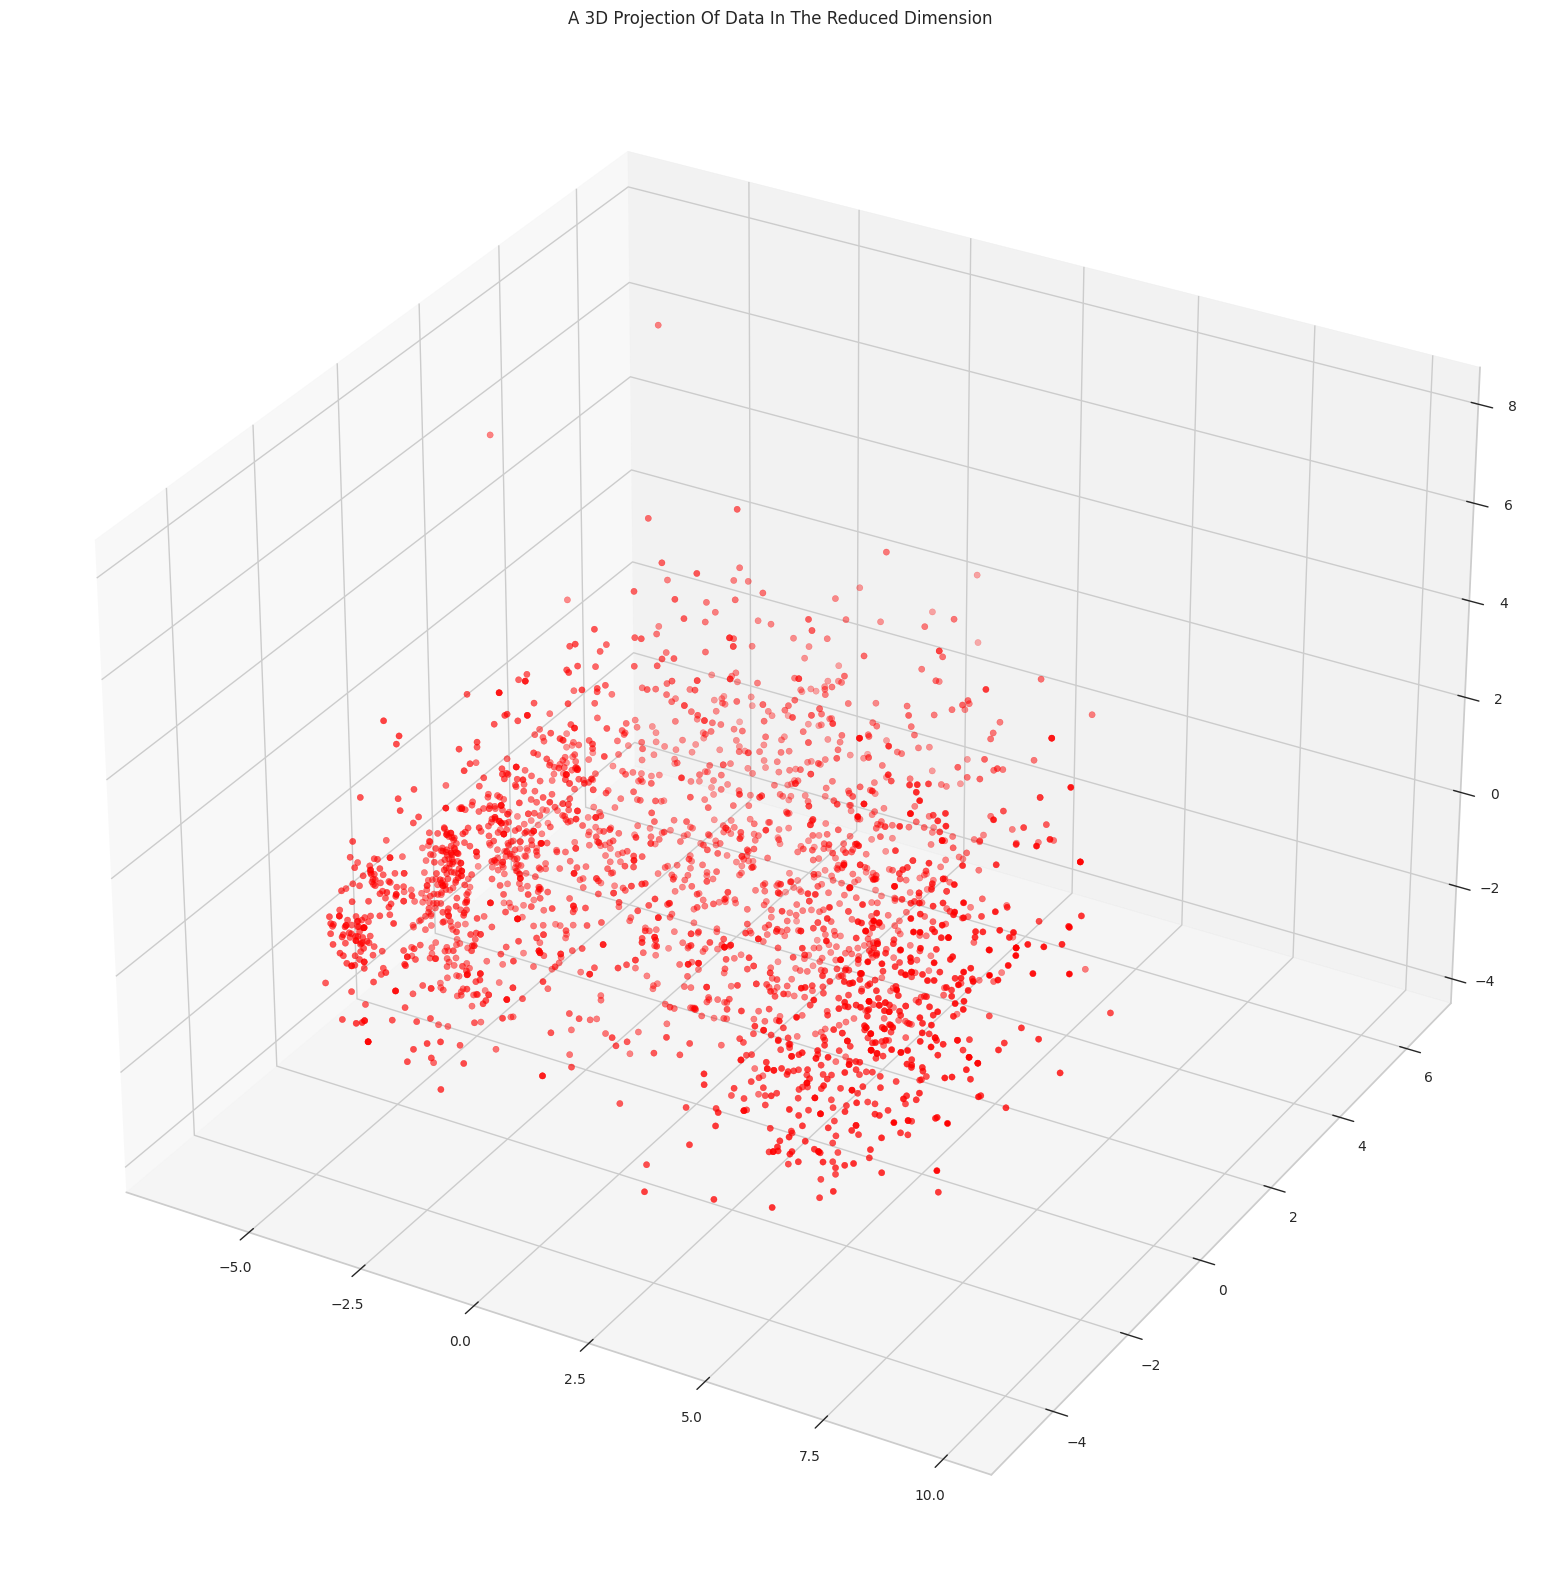

In [22]:
#A 3D Projection Of Data In The Reduced Dimension
x =customer_pca["PC1"]
y =customer_pca["PC2"]
z =customer_pca["PC3"]
#To plot
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="red", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering : Unsupervised Learning

## Determining optimum number of clusters using the elbow method

Elbow Method to determine the number of clusters to be formed:


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

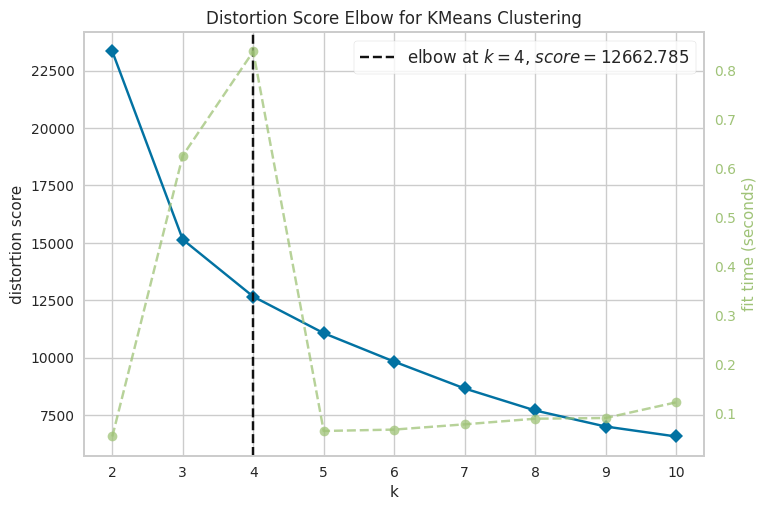

<Figure size 2500x2000 with 0 Axes>

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(customer_pca)
fig = plt.figure(figsize=(25,20))
Elbow_M.show()

With the WCSS Elbow method, we can see that the optimal number of clusters is 4.   
Let's visualize the clusters with multiple clustering algortihms, starting with KMeans.

# KMeans Clustering

In [24]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Set a random state for reproducibility

yhat_KC = kmeans.fit_predict(customer_pca)
customer_pca["km_clusters"] = yhat_KC
#Adding the Clusters feature to the orignal dataframe.
data["km_clusters"] = yhat_KC
customer["km_clusters"] = yhat_KC

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


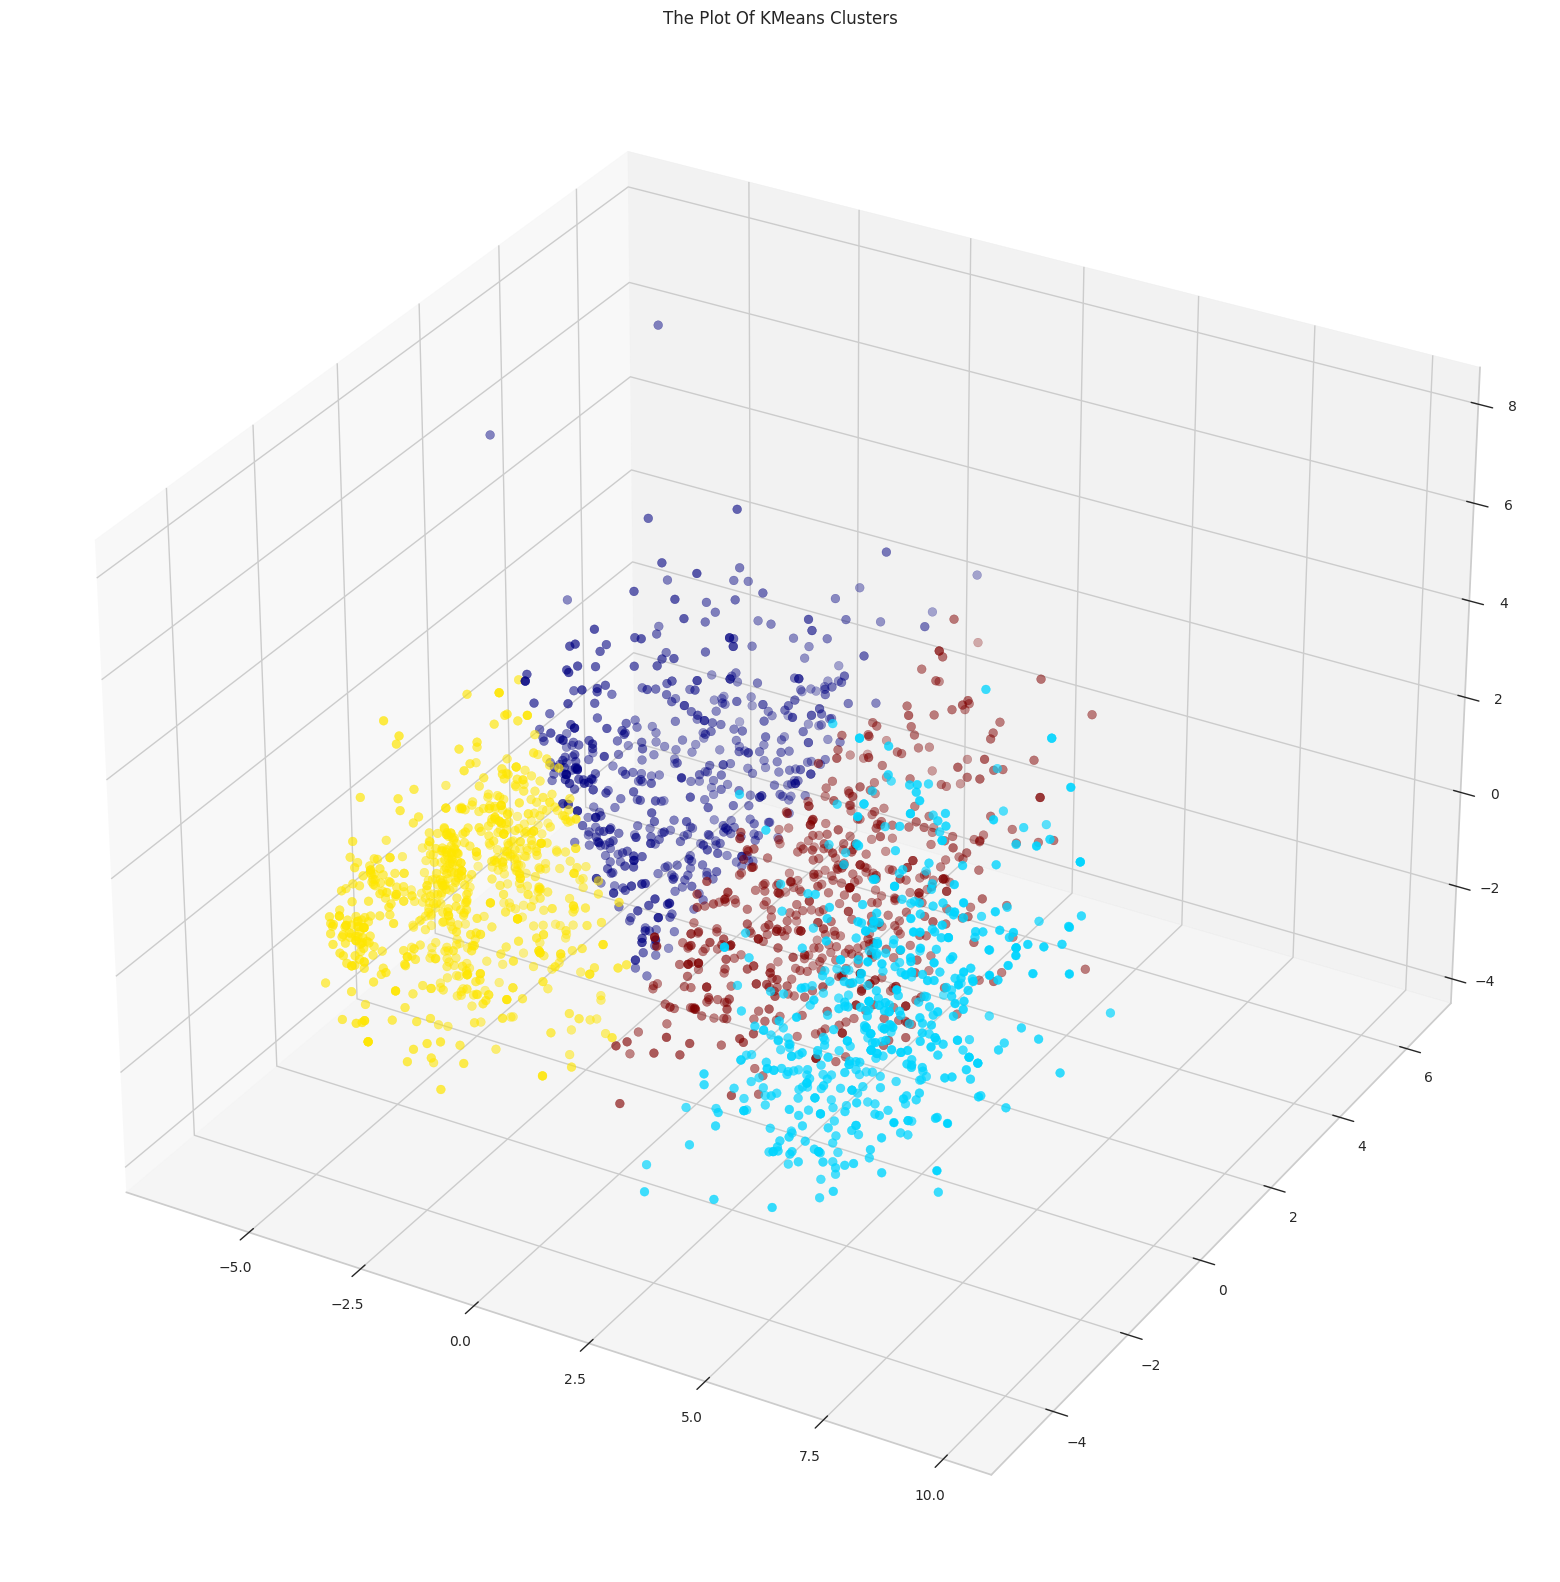

In [25]:
#Plotting the clusters
fig = plt.figure(figsize=(25,20))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=customer_pca["km_clusters"], marker='o', cmap = 'jet')
ax.set_title("The Plot Of KMeans Clusters")
plt.show()

In [26]:
silhouette_coeff = silhouette_score(customer_pca, customer_pca["km_clusters"].values)
print('Silhouette Score:', silhouette_coeff)

Silhouette Score: 0.42242302824286854


KMeans finds spherical clusters, which may not be the best for our dataset. Let's try Agglomerative.   
# Agglomerative Clustering

Elbow Method to determine the number of clusters to be formed:


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

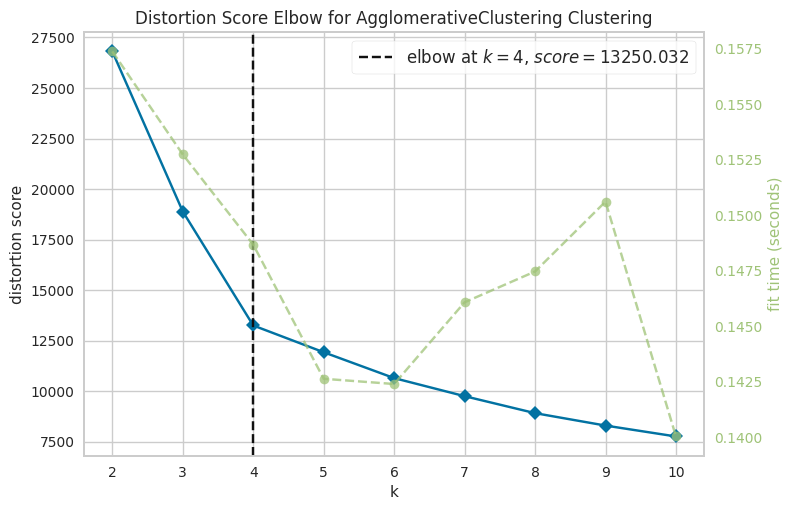

<Figure size 2000x1500 with 0 Axes>

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
print('Elbow Method to determine the number of clusters to be formed:')
agg_cluster = AgglomerativeClustering(affinity='euclidean',
                                  linkage='ward')
Elbow_M = KElbowVisualizer(agg_cluster, k=10)
Elbow_M.fit(customer_pca)
fig = plt.figure(figsize=(20,15))
Elbow_M.show()

In [28]:
agg_cluster = AgglomerativeClustering(n_clusters=4,  # Determine the number later
                                  affinity='euclidean',
                                  linkage='ward')
#agg_cluster.fit(customer_pca)

yhat_AC = agg_cluster.fit_predict(customer_pca)
customer_pca["agg_clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["agg_clusters"] = yhat_AC
customer["agg_clusters"] = yhat_AC

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


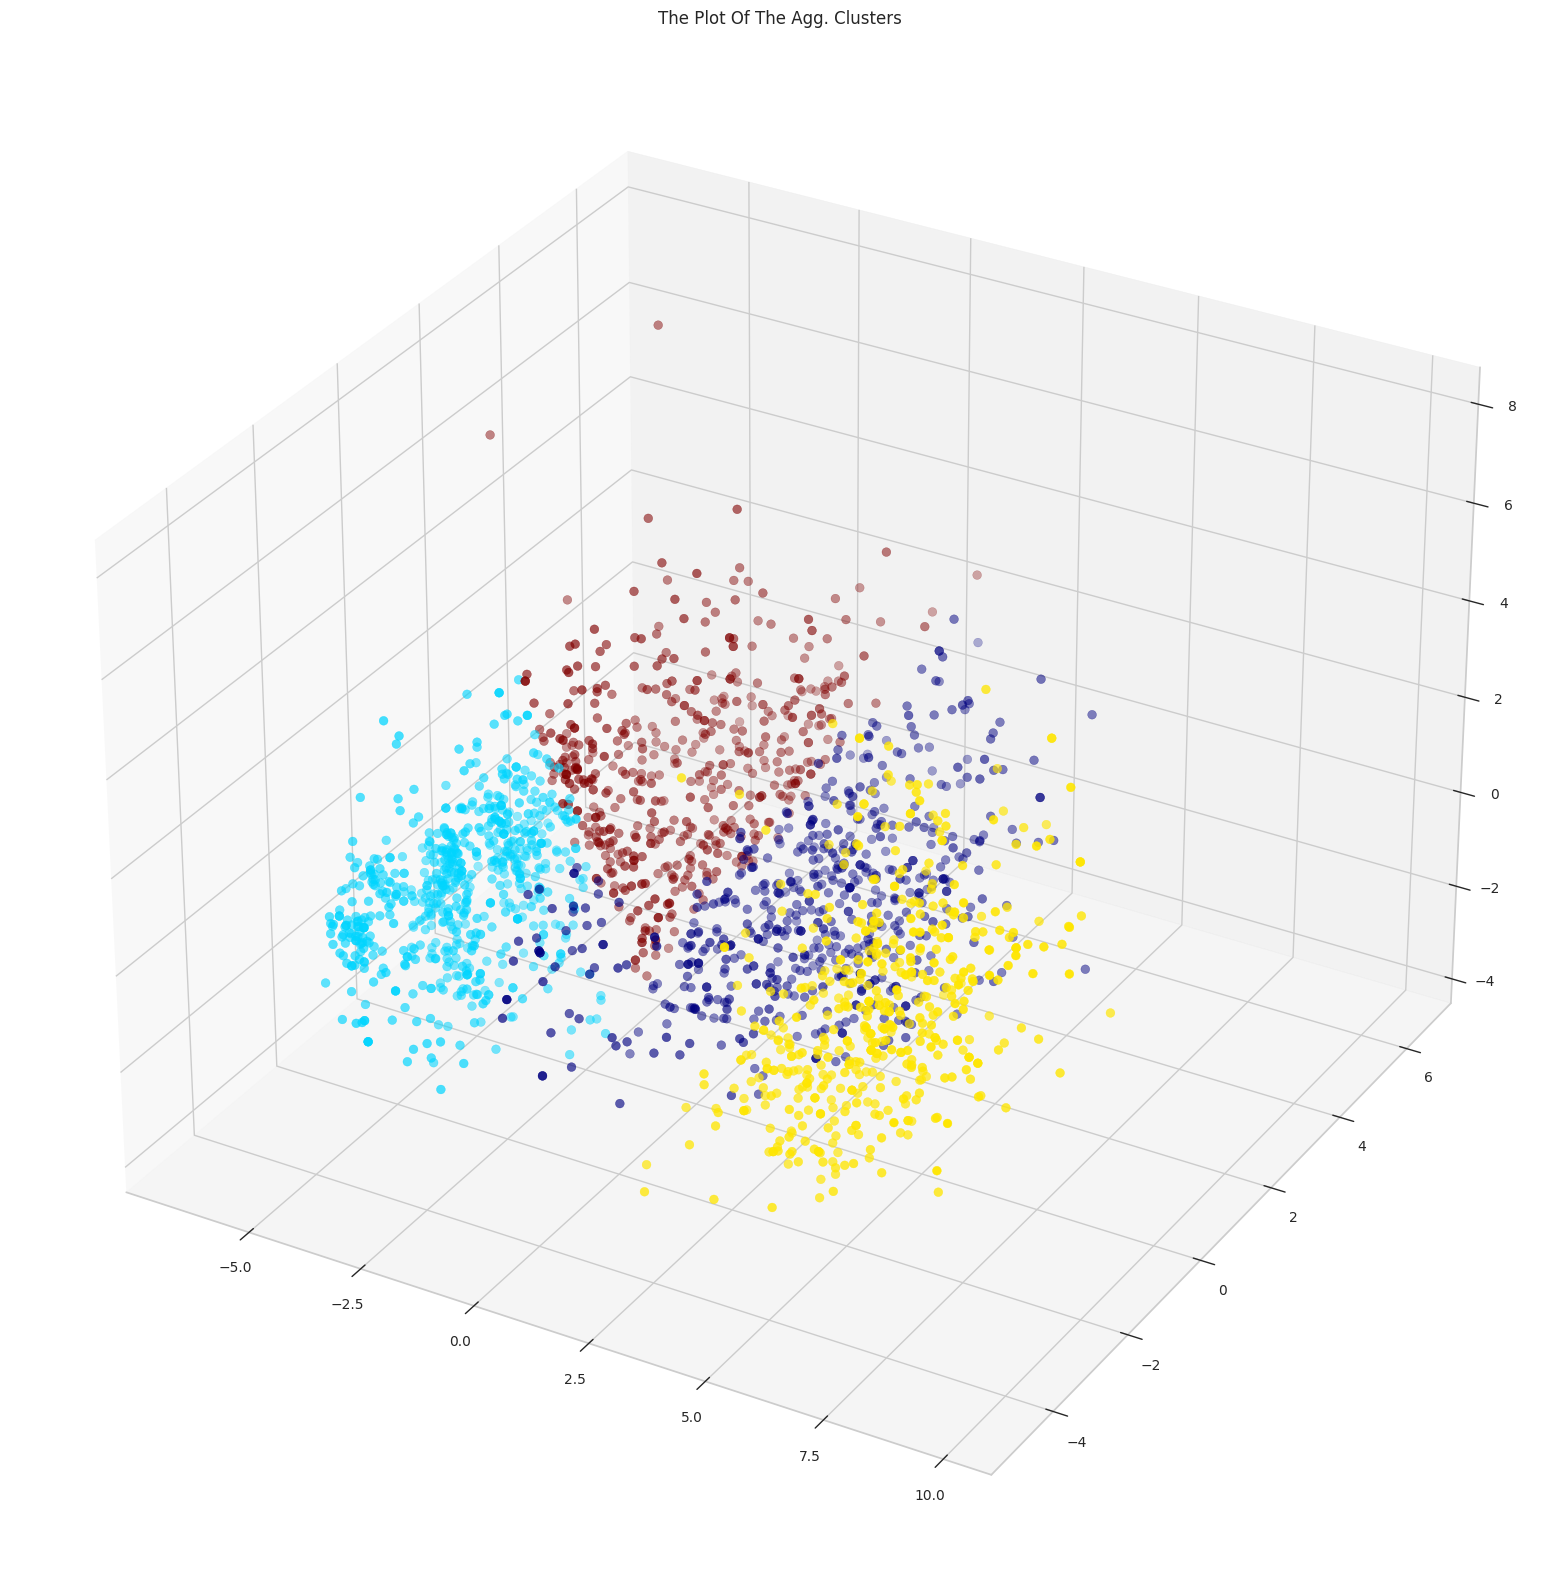

In [29]:
#Plotting the clusters
fig = plt.figure(figsize=(25,20))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=customer_pca["agg_clusters"], marker='o', cmap = 'jet' )
ax.set_title("The Plot Of The Agg. Clusters")
plt.show()

In [30]:
silhouette_coeff = silhouette_score(customer_pca, customer_pca["agg_clusters"].values)
print('Silhouette Score:', silhouette_coeff)

Silhouette Score: 0.45610695709495397


# Cluster Visualisation

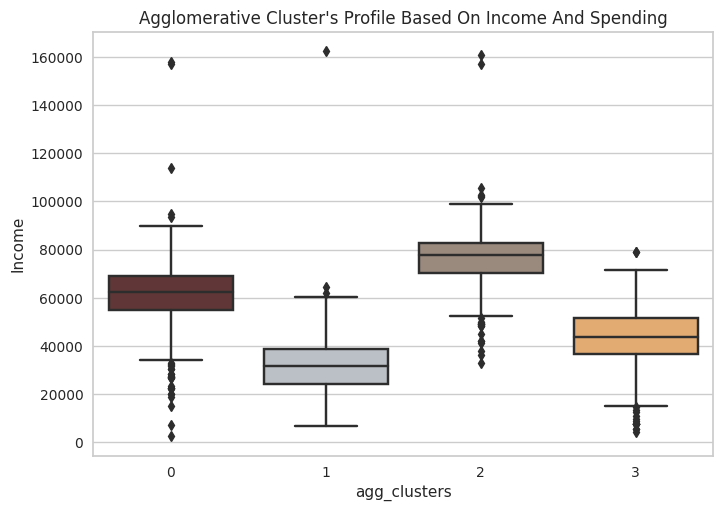

In [31]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.boxplot(data = data, x=data["agg_clusters"], y=data["Income"], palette = pal)
pl.set_title("Agglomerative Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

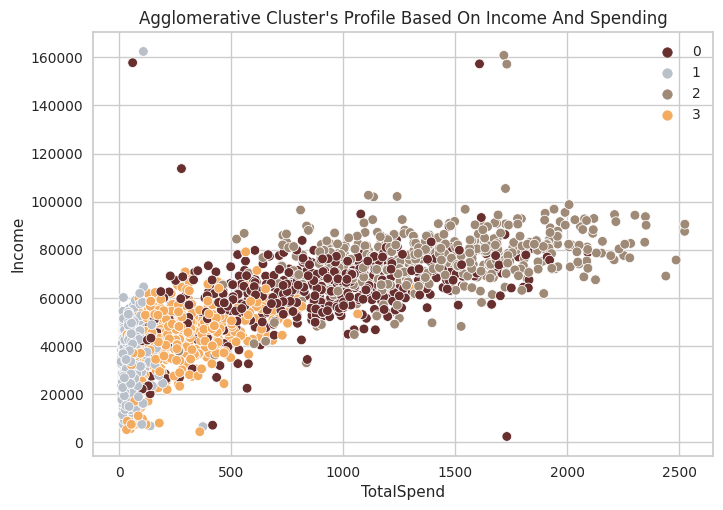

In [32]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]

pl = sns.scatterplot(data = data,x=data["TotalSpend"], y=data["Income"],hue=data["agg_clusters"], palette= pal)
pl.set_title("Agglomerative Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

# Customer Profiling
Now let's identify the cluster features to correctly profile the customers. 
We'll identify them using the following features -    

1. Income
2. Kidhome
3. Teenhome
4. Recency
5. Age
6. customerActiveAge
7. isParentBool
8. isMarriedBool
9. householdSize
10. avgPurchaseValue

In [33]:
profiling_features = ['Income','TotalSpend','Kidhome','Teenhome','Recency','Age',
                      'customerActiveAge','isParentBool','isMarriedBool','householdSize','avgPurchaseValue','NumDealsPurchases',
                     'campaignSuccessBool']

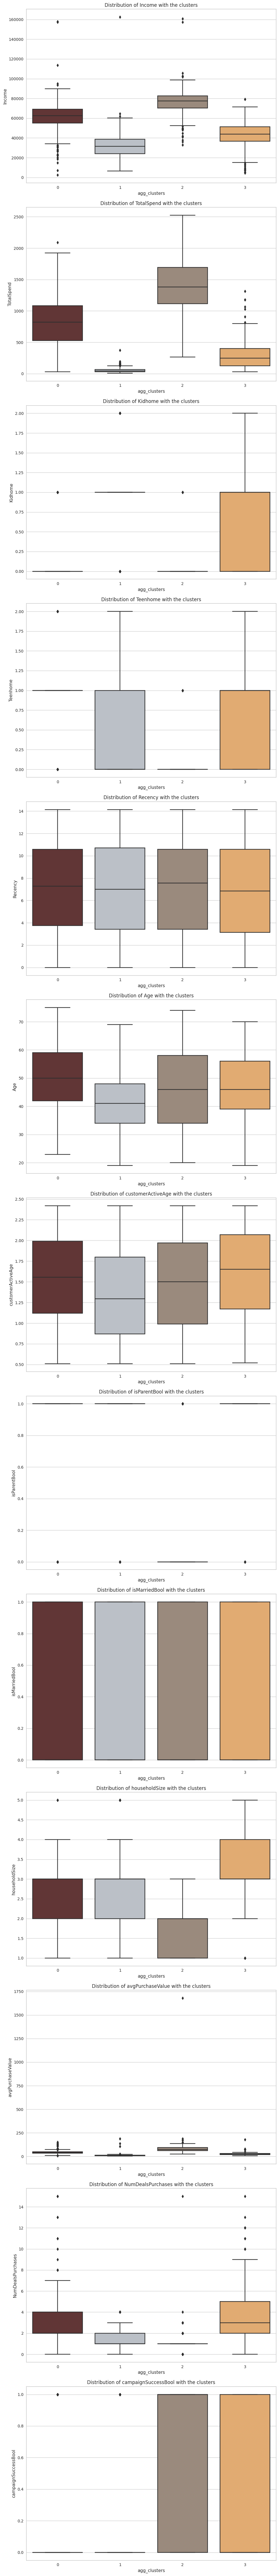

In [34]:
fig, axs = plt.subplots(nrows = len(profiling_features), ncols = 1,figsize = (10,len(profiling_features)*7))

for i, j in enumerate(profiling_features):
    sns.boxplot(data = data, x=data["agg_clusters"], y=data[j], palette = pal, ax=axs[i])
    axs[i].set_title(f"Distribution of {j} with the clusters")

        
plt.tight_layout()  # Adjust spacing between subplots
plt.show()
    
    

<Figure size 800x550 with 0 Axes>

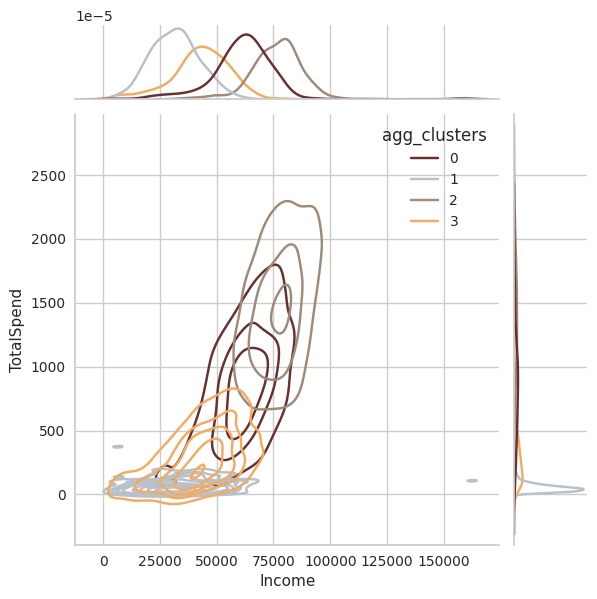

<Figure size 800x550 with 0 Axes>

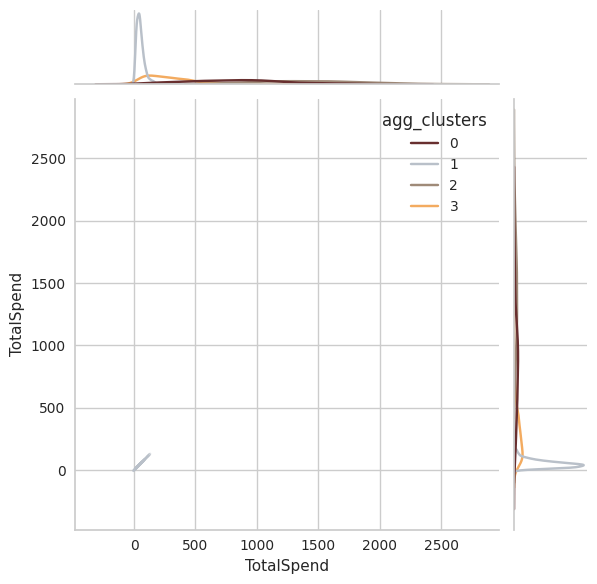

<Figure size 800x550 with 0 Axes>

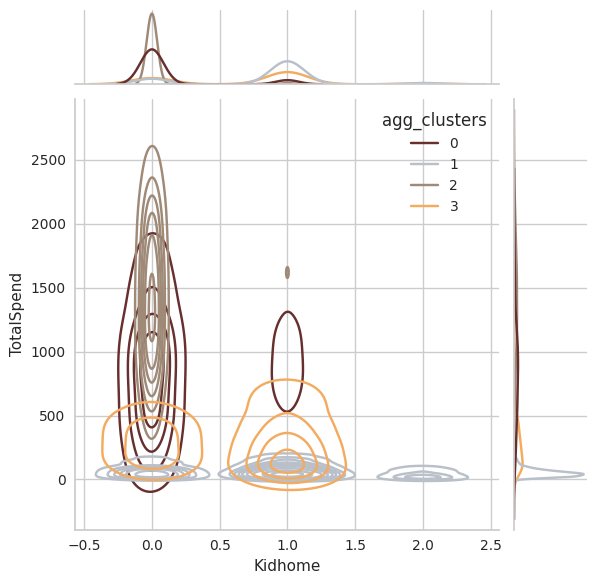

<Figure size 800x550 with 0 Axes>

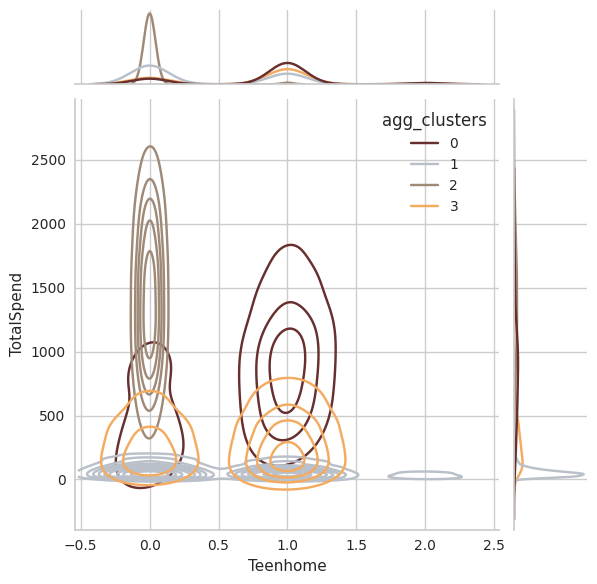

<Figure size 800x550 with 0 Axes>

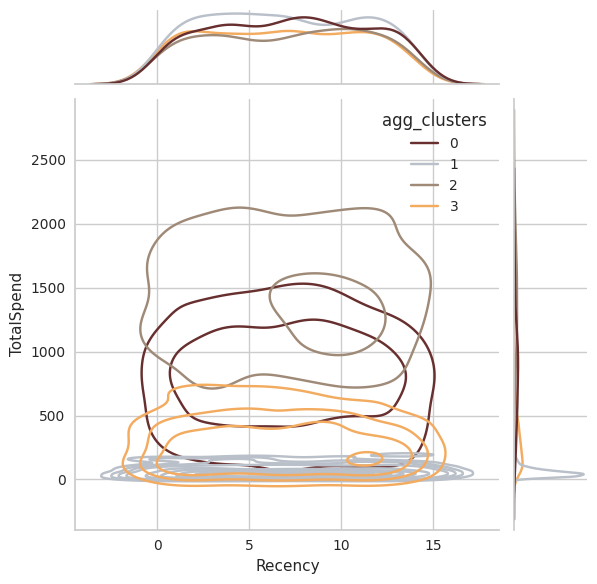

<Figure size 800x550 with 0 Axes>

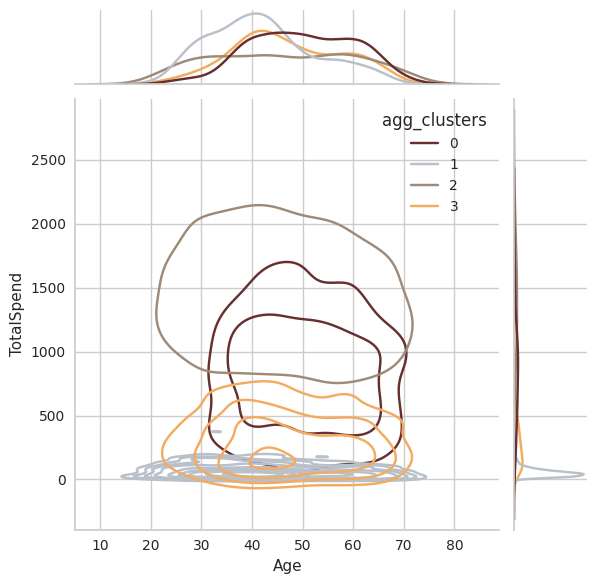

<Figure size 800x550 with 0 Axes>

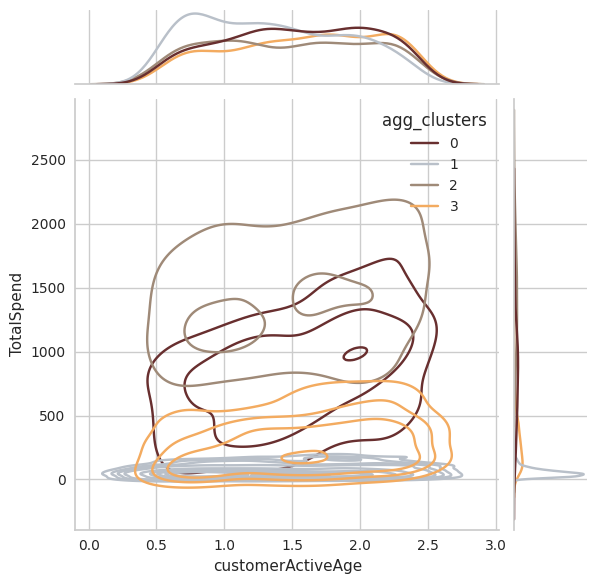

<Figure size 800x550 with 0 Axes>

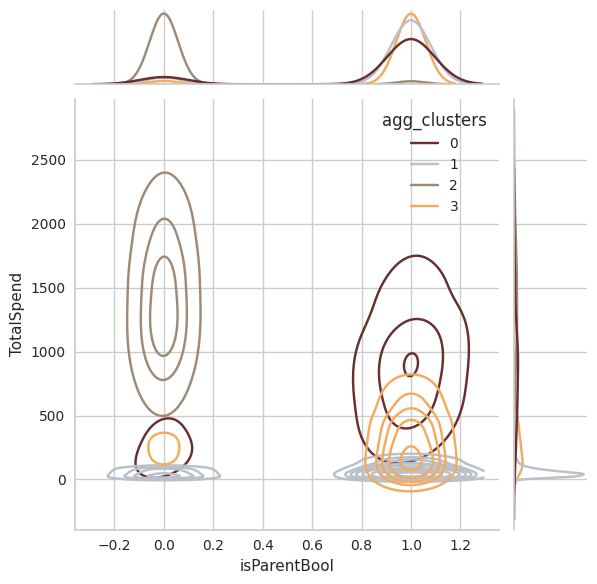

<Figure size 800x550 with 0 Axes>

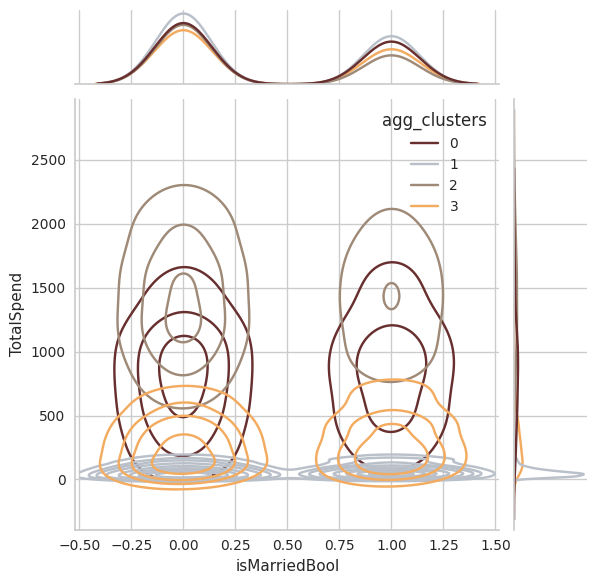

<Figure size 800x550 with 0 Axes>

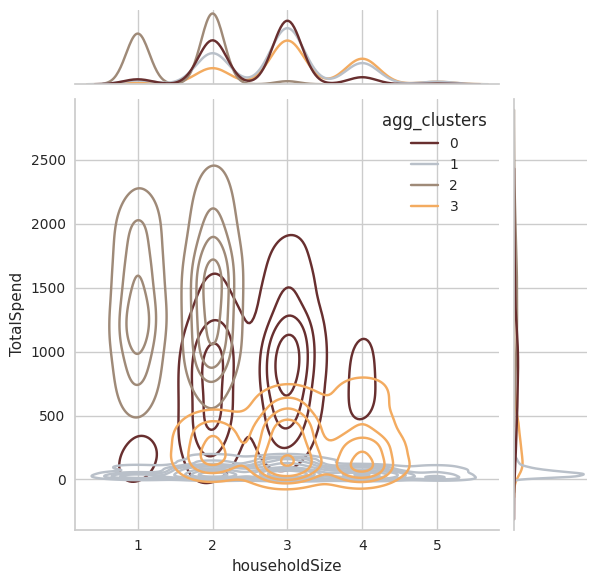

<Figure size 800x550 with 0 Axes>

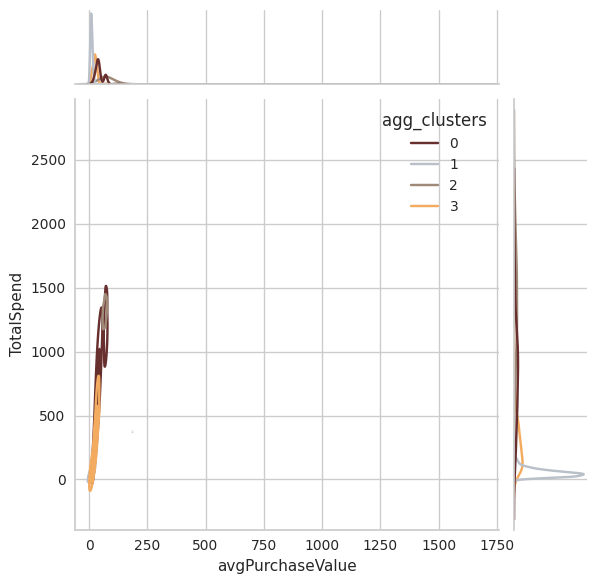

<Figure size 800x550 with 0 Axes>

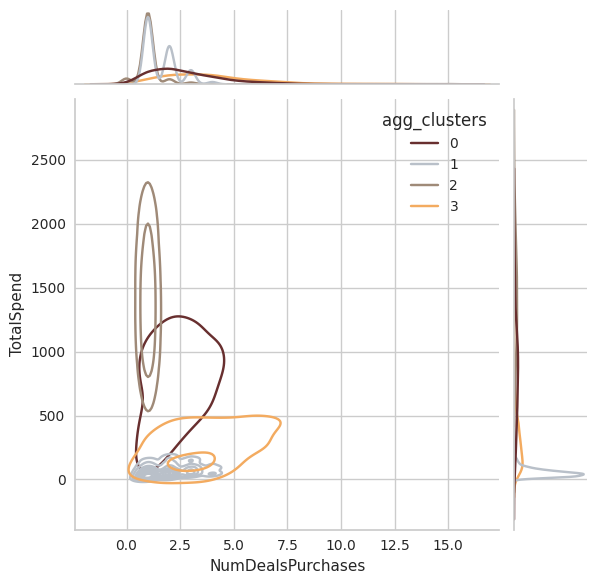

<Figure size 800x550 with 0 Axes>

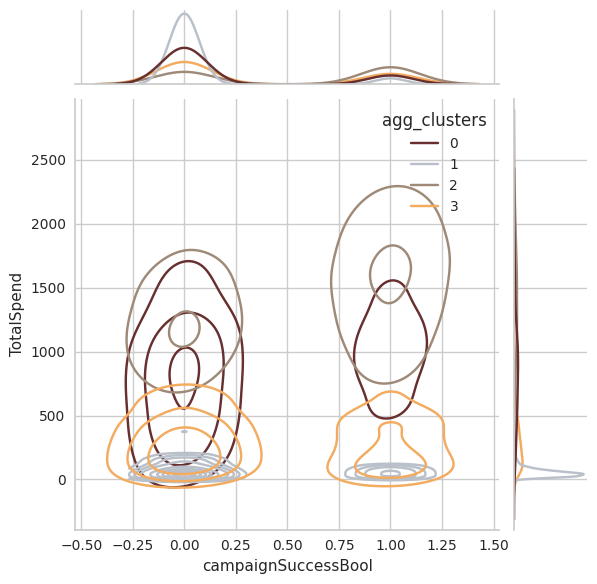

In [35]:
for i in profiling_features:
    plt.figure()
    sns.jointplot(x=data[i], y=data["TotalSpend"], hue =data["agg_clusters"], kind="kde", palette=pal)
    plt.show()

# Final Analysis : 

<img src="https://github.com/high-in-entropy/customer_profiling/blob/main/Cluster%20Profiling.png?raw=true">

# Model Training : Xgboost

We can fit a simple Xgboost model to auto classify new customers into these clusters. A human mind can later be employed to make sense of the classification.

In [36]:
customer.head()

Education  Marital_Status    Income   Kidhome  Teenhome   Recency  \
0  -0.351371        1.350105  0.294012 -0.825281 -0.932120  0.307399   
1  -0.351371        1.350105 -0.263091  1.031809  0.904123 -0.383211   
2  -0.351371       -0.740683  0.930520 -0.825281 -0.932120 -0.797578   
3  -0.351371       -0.740683 -1.193548  1.031809 -0.932120 -0.797578   
4   1.429441       -0.740683  0.301334  1.031809 -0.932120  1.550498   

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0  0.980560   1.551219         1.676734         2.457452          1.472508   
1 -0.873252  -0.637650        -0.714986        -0.651741         -0.632857   
2  0.359652   0.570002        -0.179063         1.341800         -0.148866   
3 -0.873252  -0.562172        -0.652978        -0.505426         -0.584458   
4 -0.391974   0.419045        -0.218925         0.152991         -0.003668   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0      0.843088           0.359447         1.405894             2.506784   
1     -0.731653          -0.168247        -1.116636            -0.571292   
2     -0.040303          -0.695941         1.405894            -0.229284   
3     -0.750857          -0.168247        -0.756274            -0.913301   
4     -0.558815           1.414835         0.324810             0.112725   

   NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0          -0.558874           0.715194     -0.280817     -0.284517   
1          -1.176001          -0.127767     -0.280817     -0.284517   
2           1.292508          -0.549247     -0.280817     -0.284517   
3          -0.558874           0.293713     -0.280817     -0.284517   
4           0.058254          -0.127767     -0.280817     -0.284517   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  TotalSpend  \
0     -0.279887     -0.262739     -0.116775  -0.09513  2.382571    1.677483   
1     -0.279887     -0.262739     -0.116775  -0.09513 -0.419715   -0.964872   
2     -0.279887     -0.262739     -0.116775  -0.09513 -0.419715    0.279860   
3     -0.279887     -0.262739     -0.116775  -0.09513 -0.419715   -0.921664   
4     -0.279887     -0.262739     -0.116775  -0.09513 -0.419715   -0.308438   

   TotalPurchaseCount  inStorePercent  cataloguePercent  onlinePercent  \
0            1.310998       -2.165340          2.060991       0.277416   
1           -1.194165       -0.036297          0.606245      -0.654722   
2            1.032647       -0.036297         -0.460569       0.575700   
3           -0.915814        1.078915         -1.171779       0.028846   
4            0.197592       -0.514246          0.352241       0.224151   

   inStoreToRemoteRatio  CatDealsPurchases  discountedPurchasePercent  \
0             -1.281862          -0.425500                  -0.312524   
1             -0.222439          -0.425500                   0.706557   
2             -0.222439          -0.425500                  -0.554556   
3              1.139676          -0.425500                   0.239478   
4             -0.562968           1.678415                   0.306204   

   campaignSuccessBool  convertedWebVisits  catalogueCustomerBool       Age  \
0             1.633329           -0.579422               0.592196  1.017007   
1            -0.612247            1.304959               0.592196  1.273270   
2            -0.612247           -0.750730               0.592196  0.333640   
3            -0.612247            0.391320              -1.688629 -1.289358   
4            -0.612247           -0.522320               0.592196 -1.033095   

   customerActiveAge  kidAtHomeBool  teenAtHomeBool  isParentBool  \
0           1.535245      -0.855986       -0.969087     -1.588366   
1          -1.192792       1.168244        1.031899      0.629578   
2          -0.217203      -0.855986       -0.969087     -1.588366   
3          -1.066327       1.168244       -0.969087      0.629578   
4          -0.957928       1.168244   

In [37]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  2230 non-null   float64
 1   Marital_Status             2230 non-null   float64
 2   Income                     2230 non-null   float64
 3   Kidhome                    2230 non-null   float64
 4   Teenhome                   2230 non-null   float64
 5   Recency                    2230 non-null   float64
 6   MntWines                   2230 non-null   float64
 7   MntFruits                  2230 non-null   float64
 8   MntMeatProducts            2230 non-null   float64
 9   MntFishProducts            2230 non-null   float64
 10  MntSweetProducts           2230 non-null   float64
 11  MntGoldProds               2230 non-null   float64
 12  NumDealsPurchases          2230 non-null   float64
 13  NumWebPurchases            2230 non-null   float

# Cluster Distribution - Stratified Train-test Split

In [38]:
customer = customer.drop(['km_clusters'],axis = 1)

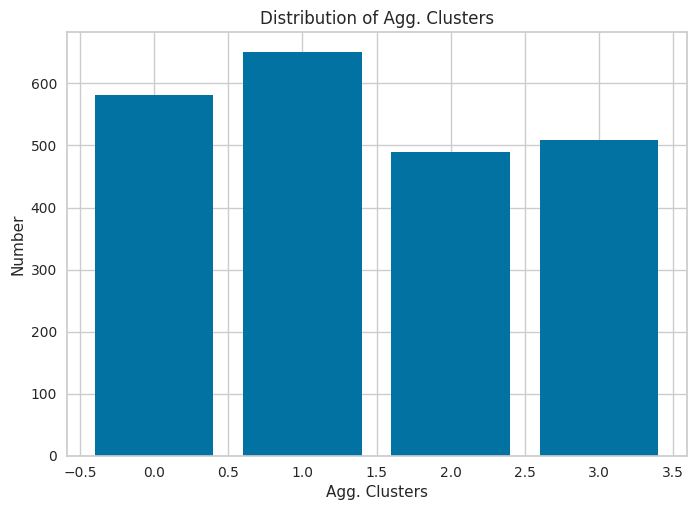

In [39]:
n_category = customer['agg_clusters'].value_counts().sort_values(ascending=False)

# Create a bar chart to visualize the distribution
plt.bar(n_category.index, n_category.values)
plt.xlabel('Agg. Clusters')
plt.ylabel('Number')
plt.title('Distribution of Agg. Clusters')
plt.show()

Clusters are well distributed. Let's do a stratified train-test split of the dataset basis the clusters column.

In [40]:
categorical_column = "agg_clusters"

# Separate features and target variable (optional)
features = customer.drop(categorical_column, axis=1)  # Assuming target variable is not the categorical column
target = customer[categorical_column]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

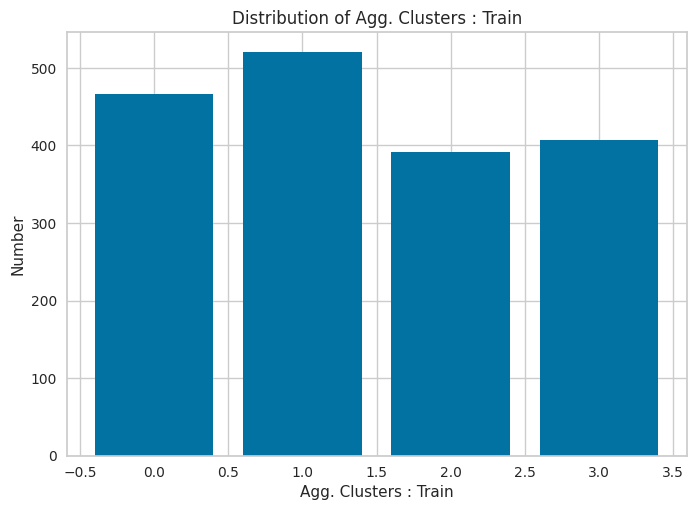

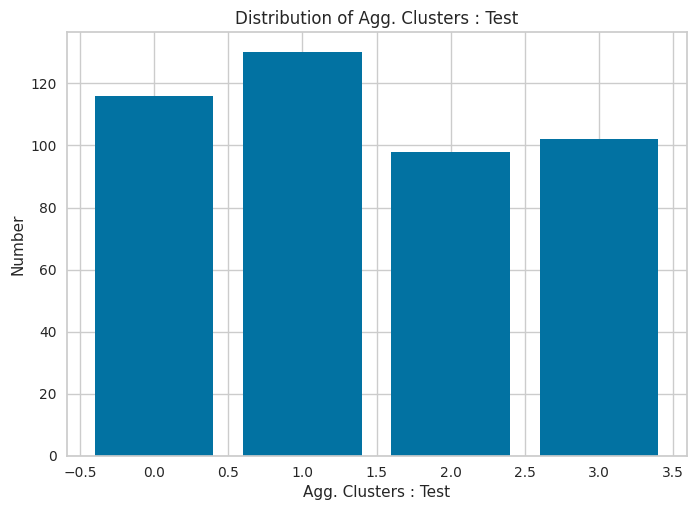

In [41]:
n_category = y_train.value_counts().sort_values(ascending=False)

# Create a bar chart to visualize the distribution
plt.bar(n_category.index, n_category.values)
plt.xlabel('Agg. Clusters : Train')
plt.ylabel('Number')
plt.title('Distribution of Agg. Clusters : Train')
plt.show()
n_category = y_test.value_counts().sort_values(ascending=False)

# Create a bar chart to visualize the distribution
plt.bar(n_category.index, n_category.values)
plt.xlabel('Agg. Clusters : Test')
plt.ylabel('Number')
plt.title('Distribution of Agg. Clusters : Test')
plt.show()


# Train an XGboost model

In [42]:
xgb_params = {
    "objective": "multi:softprob", 
    "learning_rate": 0.1,
    "n_estimators": 300,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0,  # L1 regularization parameter
    "lambda": 1,  # L2 regularization parameter
    "random_state": 42,
}

# Create and train the XGBoost model
model = XGBClassifier(**xgb_params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds = 10)

# Make predictions on the test set (or new data)
predictions = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

[0]	validation_0-mlogloss:1.23345
[1]	validation_0-mlogloss:1.10892
[2]	validation_0-mlogloss:0.99932
[3]	validation_0-mlogloss:0.90664
[4]	validation_0-mlogloss:0.82820
[5]	validation_0-mlogloss:0.76189
[6]	validation_0-mlogloss:0.70406
[7]	validation_0-mlogloss:0.65181
[8]	validation_0-mlogloss:0.60384
[9]	validation_0-mlogloss:0.56235
[10]	validation_0-mlogloss:0.52538
[11]	validation_0-mlogloss:0.49295
[12]	validation_0-mlogloss:0.46431
[13]	validation_0-mlogloss:0.43577
[14]	validation_0-mlogloss:0.41069


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mlogloss:0.38879
[16]	validation_0-mlogloss:0.36871
[17]	validation_0-mlogloss:0.35159
[18]	validation_0-mlogloss:0.33613
[19]	validation_0-mlogloss:0.32224
[20]	validation_0-mlogloss:0.30837
[21]	validation_0-mlogloss:0.29763
[22]	validation_0-mlogloss:0.28733
[23]	validation_0-mlogloss:0.27684
[24]	validation_0-mlogloss:0.26806
[25]	validation_0-mlogloss:0.26002
[26]	validation_0-mlogloss:0.25290
[27]	validation_0-mlogloss:0.24509
[28]	validation_0-mlogloss:0.23897
[29]	validation_0-mlogloss:0.23349
[30]	validation_0-mlogloss:0.22831
[31]	validation_0-mlogloss:0.22297
[32]	validation_0-mlogloss:0.21779
[33]	validation_0-mlogloss:0.21296
[34]	validation_0-mlogloss:0.20982
[35]	validation_0-mlogloss:0.20586
[36]	validation_0-mlogloss:0.20292
[37]	validation_0-mlogloss:0.19974
[38]	validation_0-mlogloss:0.19722
[39]	validation_0-mlogloss:0.19398
[40]	validation_0-mlogloss:0.19121
[41]	validation_0-mlogloss:0.18909
[42]	validation_0-mlogloss:0.18754
[43]	validation_0-ml

# XGBoost Feature Importance

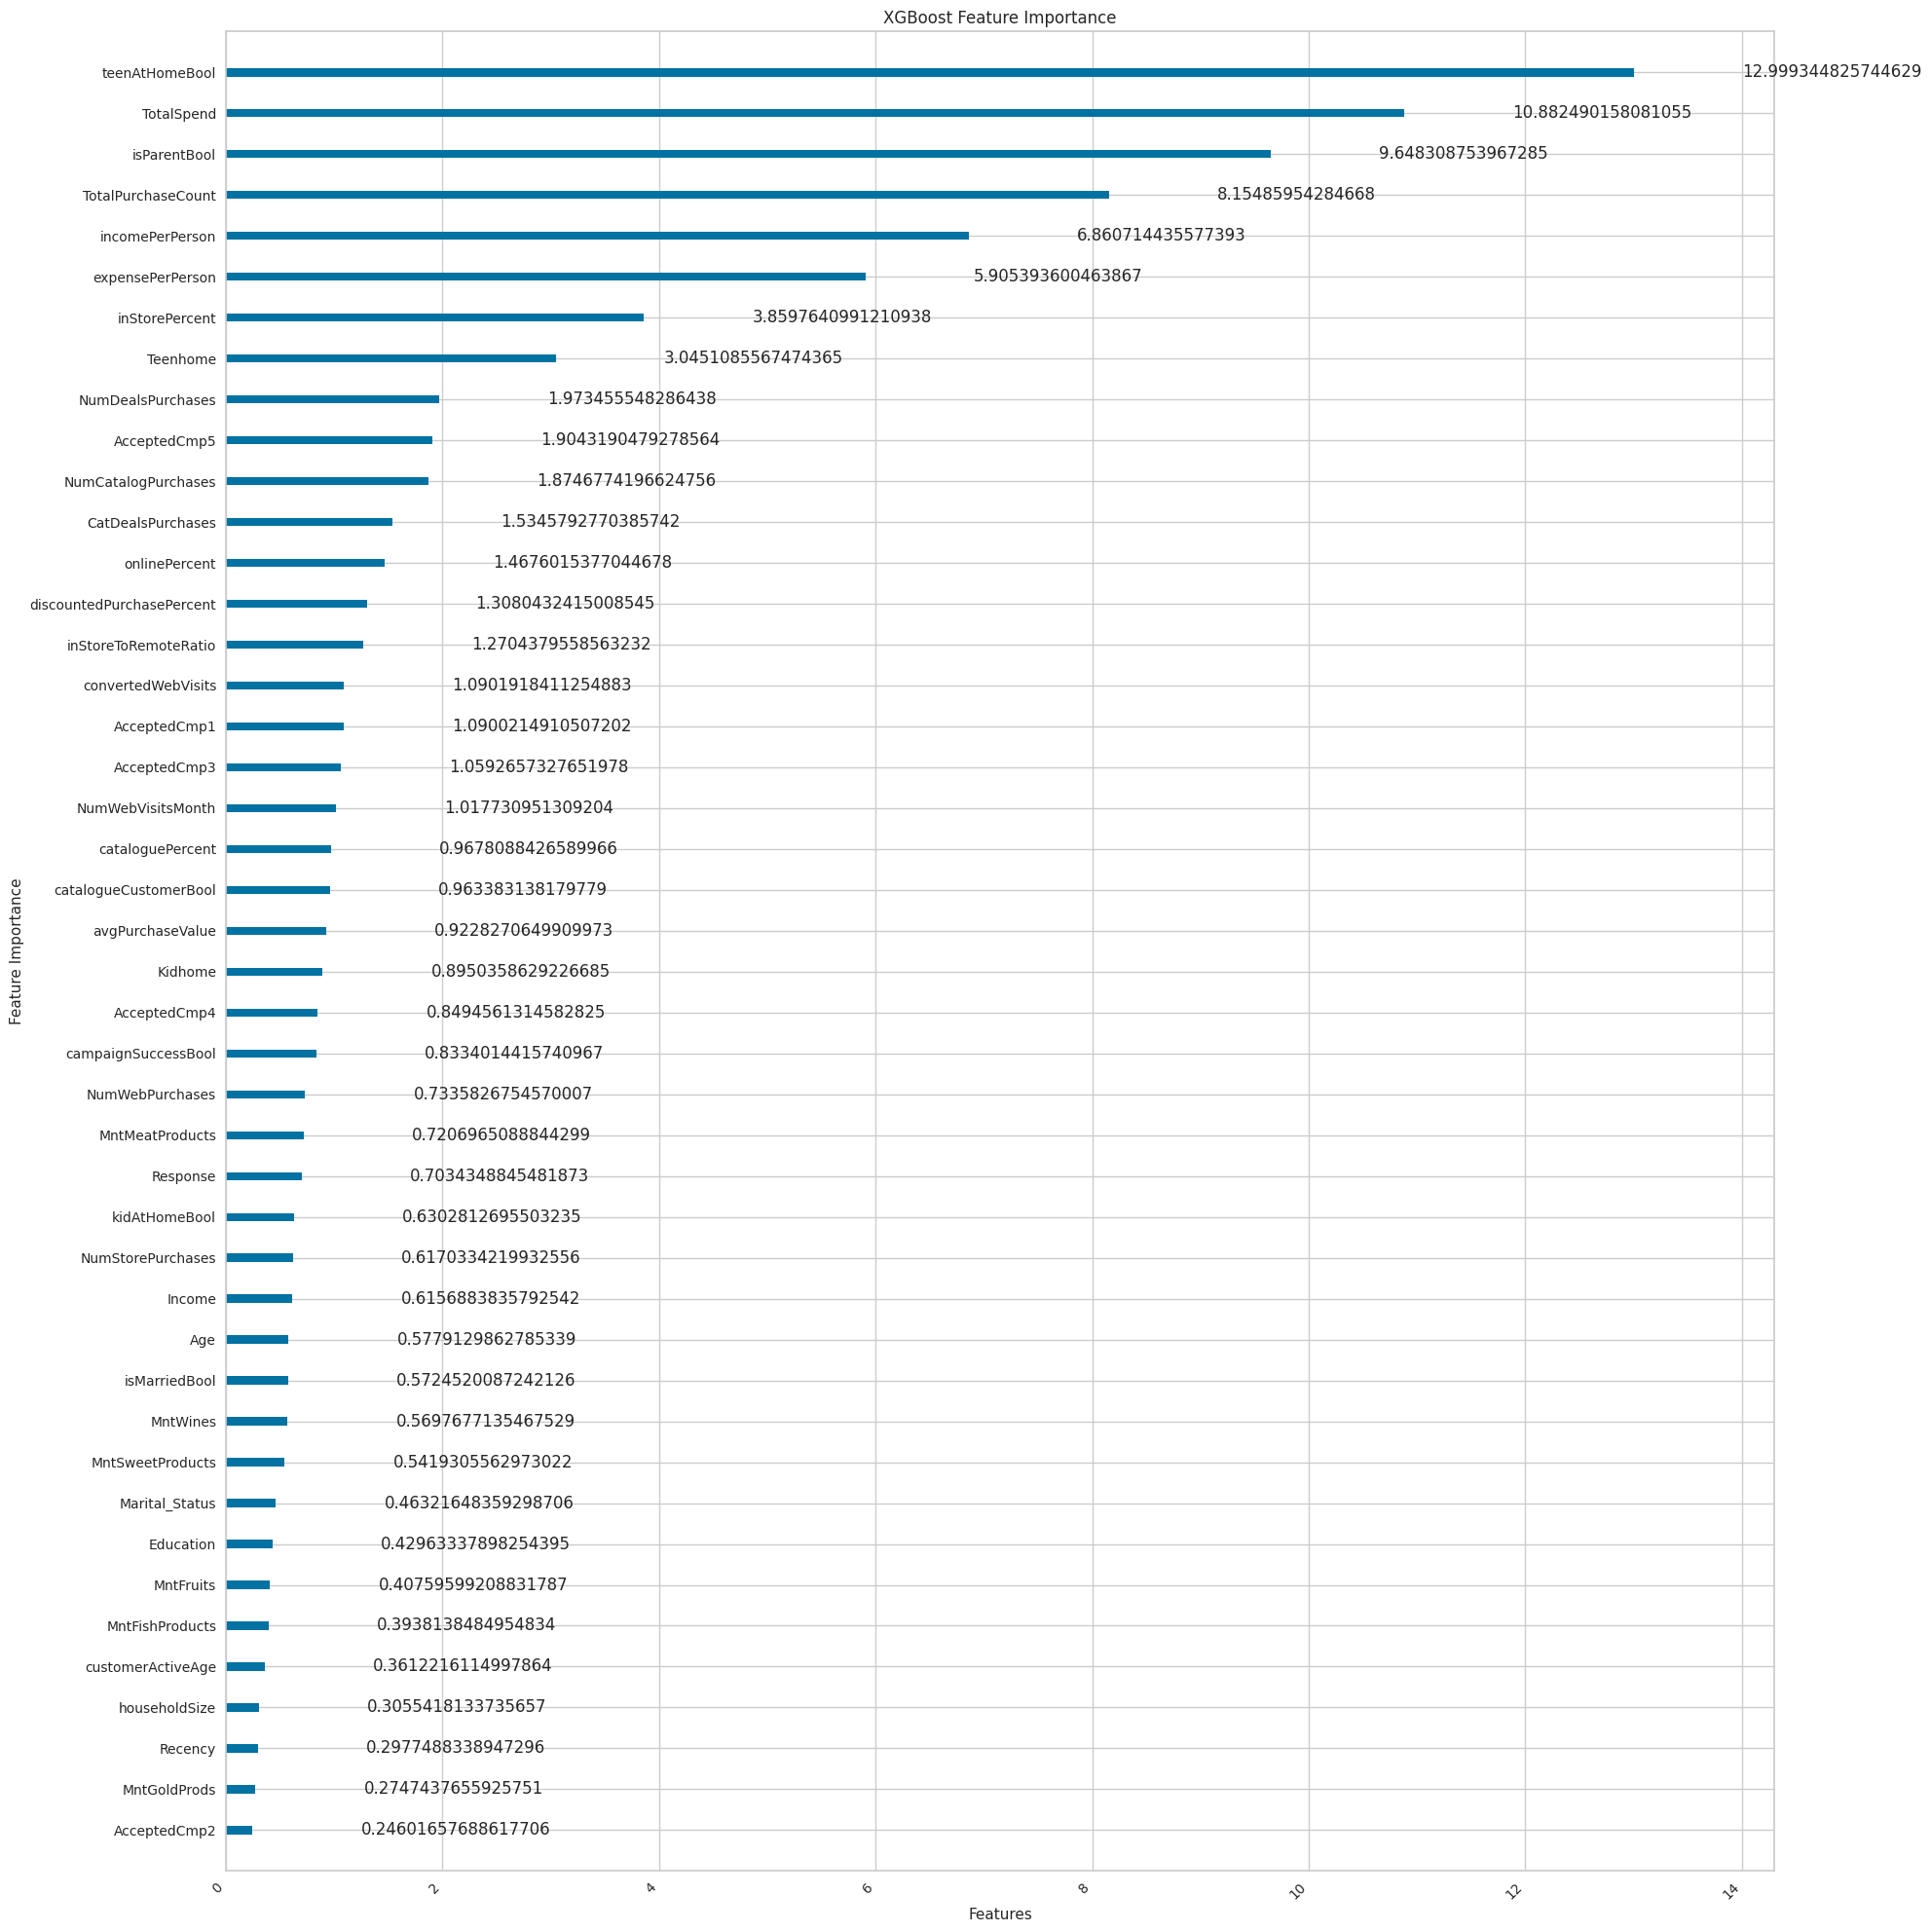

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have a trained XGBoost model (model)
# Choose the type of importance you want to plot (gain, weight, etc.)
importance_type = 'gain'

# Get feature importances
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(model, ax=ax, importance_type=importance_type)
ax.set_title('XGBoost Feature Importance')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()